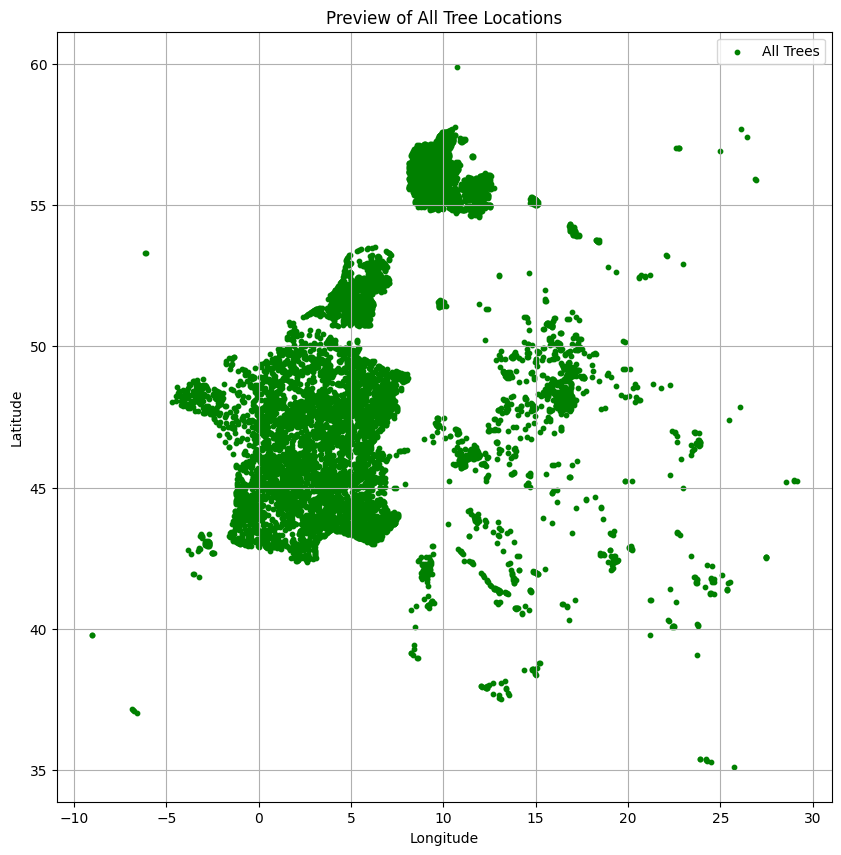

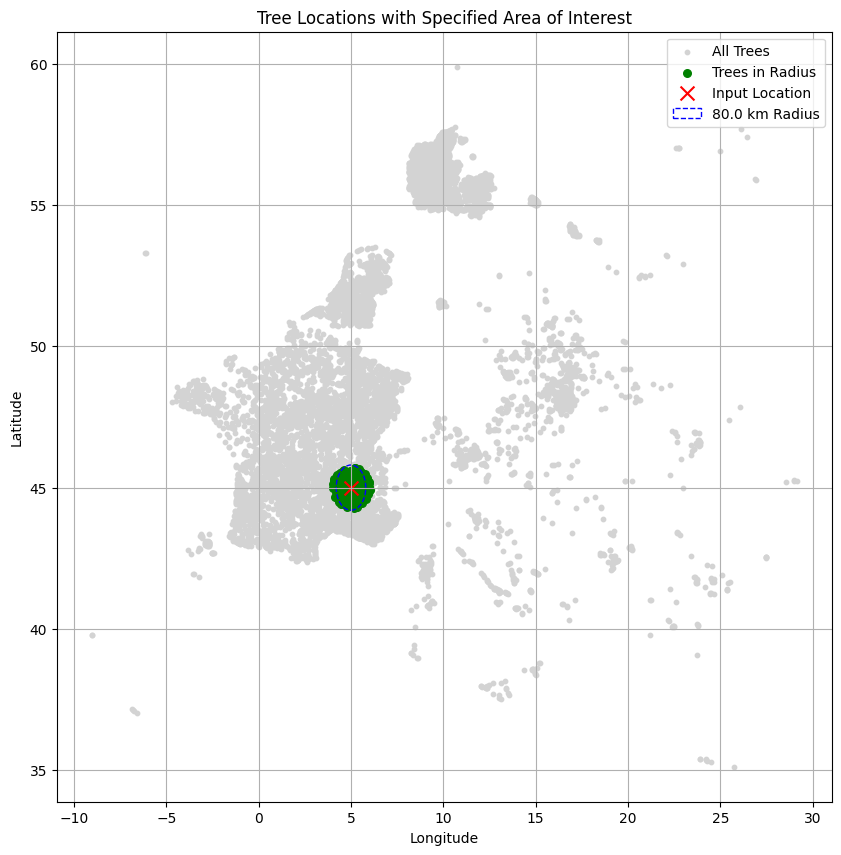

AHP Criteria Weights: {'AQI_Impact': 0.618, 'Species_Importance': 0.247, 'Tree_Density': 0.074, 'distance_to_urban': 0.049, 'distance_to_water': 0.012}
Consistency Ratio: 0.005
Ranked Trees/Clusters for Preservation/Removal with Location-Based Reasoning:

Species ID: [8424.0, 10073.0, 10896.0, 5412.0, 10228.0, 4871.0, 1215.0, 694.0, 8549.0, 3020.0, 963.0, 4102.0, 5335.0, 3935.0, 8807.0, 6689.0, 868.0, 4238.0, 11120.0, 8106.0, 10664.0, 10991.0, 6331.0, 799.0, 1888.0, 146.0, 11140.0, 3457.0, 2109.0, 9388.0, 5542.0, 8917.0, 8770.0, 2474.0, 9028.0, 855.0, 10315.0, 7504.0, 9190.0, 1497.0, 2122.0, 1677.0, 4854.0, 981.0, 53.0, 10909.0, 6788.0, 10367.0, 7862.0, 569.0, 6143.0, 423.0, 8705.0, 5860.0, 6909.0, 5520.0, 5022.0, 10427.0, 5557.0, 6925.0, 544.0, 8208.0, 9647.0, 4795.0, 2570.0, 9261.0, 7971.0, 10385.0], Location: ([5.77312, 5.77312, 5.77312, 5.77312, 5.77312, 5.77312, 5.77312, 5.77312, 5.77312, 5.77312, 5.77312, 5.77312, 5.77312, 5.77312, 5.77312, 5.77312, 5.77312, 5.77312, 5.77312, 5.7

C:\Users\shiva\AppData\Local\Temp\ipykernel_17708\2971010412.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TOPSIS_Score'] = topsis_score


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ahpy import Compare
from sklearn.preprocessing import MinMaxScaler
from geopy.distance import geodesic

# Load and preprocess data
def load_data():
    merged_data = pd.read_csv('cluster_with_pollution_data.csv')
    merged_data['coordinates_lon'] = merged_data['coordinates_lon'].apply(eval)
    merged_data['coordinates_lat'] = merged_data['coordinates_lat'].apply(eval)
    merged_data['speciesId'] = merged_data['speciesId'].apply(eval)
    merged_data['distance_to_urban'] = merged_data.apply(lambda row: calculate_distance_to_urban(row), axis=1)
    merged_data['distance_to_water'] = merged_data.apply(lambda row: calculate_distance_to_water(row), axis=1)
    return merged_data

# Calculate distances to urban areas or water bodies
def calculate_distance_to_urban(row):
    urban_location = (42.0, -0.5)
    return geodesic((row['average_lat'], row['average_lon']), urban_location).km

def calculate_distance_to_water(row):
    water_location = (42.2, -0.7)
    return geodesic((row['average_lat'], row['average_lon']), water_location).km

# Calculate or verify criteria columns are present
def calculate_criteria(df):
    # AQI Impact, Species Importance, Tree Density
    if 'AQI_Impact' not in df.columns:
        df['AQI_Impact'] = 0.4 * df['AQI'] + 0.2 * df['CO'] + 0.2 * df['NO2'] + 0.2 * df['PM2.5']
    if 'Species_Importance' not in df.columns:
        df['Species_Importance'] = df['speciesId'].apply(lambda x: len(set(x)))
    if 'Tree_Density' not in df.columns:
        df['Tree_Density'] = df['coordinates_lon'].apply(len)
    return df

# Plot all tree locations
def plot_all_tree_locations(df):
    plt.figure(figsize=(10, 10))
    plt.scatter(df['average_lon'], df['average_lat'], c='green', s=10, label='All Trees')
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Preview of All Tree Locations")
    plt.legend()
    plt.grid(True)
    plt.show()

# AHP - Assign Weights with Location included
def calculate_ahp_weights():
    criteria = {
        ('AQI_Impact', 'Species_Importance'): 3,
        ('AQI_Impact', 'Tree_Density'): 7,
        ('Species_Importance', 'Tree_Density'): 4,
        ('Species_Importance', 'distance_to_urban'): 5,
        ('Tree_Density', 'distance_to_water'): 6,
    }
    comparison = Compare('Criteria', criteria, precision=3)
    weights = comparison.target_weights
    print("AHP Criteria Weights:", weights)
    print("Consistency Ratio:", comparison.consistency_ratio)
    return weights

# Filter trees within specified radius around given coordinates
def filter_trees_by_location(df, input_coords, radius_km):
    df['distance_to_input'] = df.apply(
        lambda row: geodesic((row['average_lat'], row['average_lon']), input_coords).km, axis=1
    )
    return df[df['distance_to_input'] <= radius_km]

# Plot location and trees within specified radius
def plot_location_and_trees(df, input_coords, radius_km):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(df['average_lon'], df['average_lat'], c='lightgray', s=10, label='All Trees')
    within_radius = filter_trees_by_location(df, input_coords, radius_km)
    ax.scatter(within_radius['average_lon'], within_radius['average_lat'], c='green', s=30, label='Trees in Radius')
    ax.scatter(input_coords[1], input_coords[0], color='red', s=100, label='Input Location', marker='x')
    circle = plt.Circle((input_coords[1], input_coords[0]), radius_km/100, color='blue', fill=False, linestyle='--', label=f'{radius_km} km Radius')
    ax.add_patch(circle)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title("Tree Locations with Specified Area of Interest")
    ax.legend()
    ax.grid(True)
    plt.show()

# TOPSIS - Rank Trees/Clusters and provide reasoning with Location
def topsis_ranking(df, weights):
    scaler = MinMaxScaler()
    criteria_data = df[['AQI_Impact', 'Species_Importance', 'Tree_Density', 'distance_to_urban', 'distance_to_water']]
    normalized_data = scaler.fit_transform(criteria_data)
    weighted_data = normalized_data * np.array(list(weights.values()))
    ideal_solution = np.max(weighted_data, axis=0)
    negative_ideal_solution = np.min(weighted_data, axis=0)

    dist_to_ideal = np.sqrt(np.sum((weighted_data - ideal_solution) ** 2, axis=1))
    dist_to_negative_ideal = np.sqrt(np.sum((weighted_data - negative_ideal_solution) ** 2, axis=1))
    topsis_score = dist_to_negative_ideal / (dist_to_ideal + dist_to_negative_ideal)
    df['TOPSIS_Score'] = topsis_score

    df = df.sort_values(by='TOPSIS_Score', ascending=False)
    print("Ranked Trees/Clusters for Preservation/Removal with Location-Based Reasoning:\n")
    for index, row in df.iterrows():
        print(f"Species ID: {row['speciesId']}, Location: ({row['coordinates_lon']}, {row['coordinates_lat']})")
        print(f"TOPSIS Score: {row['TOPSIS_Score']:.4f}")
        
        reasoning = []
        if row['AQI_Impact'] > 0.5:
            reasoning.append("High AQI Impact, essential for maintaining air quality.")
        if row['distance_to_urban'] < 5:
            reasoning.append("Close to urban area, contributing to urban air quality.")
        if row['distance_to_water'] < 2:
            reasoning.append("Close to water body, providing erosion control.")
        
        print("Reasoning:")
        for reason in reasoning:
            print(f"- {reason}")
        print("\n---\n")
    
    return df

# Main function to load data and execute AHP, TOPSIS based on location and radius input
def main():
    merged_data = load_data()
    merged_data = calculate_criteria(merged_data)
    plot_all_tree_locations(merged_data)
    
    try:
        input_lat = float(input("Enter latitude of the area: "))
        input_lon = float(input("Enter longitude of the area: "))
        radius_km = float(input("Enter radius around the area (in km): "))
    except ValueError:
        print("Invalid input. Please enter numerical values for coordinates and radius.")
        return

    input_coords = (input_lat, input_lon)
    plot_location_and_trees(merged_data, input_coords, radius_km)
    trees_in_area = filter_trees_by_location(merged_data, input_coords, radius_km)
    
    if trees_in_area.empty:
        print(f"No trees found within {radius_km} km of the specified location.")
        return
    
    weights = calculate_ahp_weights()
    
    if all(col in trees_in_area.columns for col in ['AQI_Impact', 'Species_Importance', 'Tree_Density', 'distance_to_urban', 'distance_to_water']):
        ranked_data = topsis_ranking(trees_in_area, weights)
    else:
        print("Error: Ensure that all necessary criteria columns are present.")

if __name__ == "__main__":
    main()
